In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [58]:
# Load the dataset
data_path = '/mmfs1/home/oreoluwa.alade/Online Retail.xlsx' 
df = pd.read_excel(data_path)

In [59]:
# View the first few rows of the dataset
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [60]:
# Get an overview of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [61]:
# Check for missing values
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [62]:
# Get descriptive statistics
print(df.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [63]:
# Drop rows where CustomerID is missing
df_cleaned = df.dropna(subset=['CustomerID'])

# Check for any remaining missing values
print(df_cleaned.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [64]:
# Check the structure of the cleaned dataset
print(df_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB
None


#### Feature Engineering

In [65]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Extract relevant date features
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['DayOfWeek'] = df_cleaned['InvoiceDate'].dt.dayofweek
df_cleaned['Hour'] = df_cleaned['InvoiceDate'].dt.hour

# Aggregate the data by InvoiceDate and StockCode (product)
df_grouped = df_cleaned.groupby(['StockCode', 'InvoiceDate']).agg({'Quantity': 'sum', 'UnitPrice': 'mean'}).reset_index()

# Set InvoiceDate as index and sort by date
df_grouped = df_grouped.set_index('InvoiceDate').sort_index()

# Check the first few rows of the grouped data
print(df_grouped.head())


                    StockCode  Quantity  UnitPrice
InvoiceDate                                       
2010-12-01 08:26:00    85123A         6       2.55
2010-12-01 08:26:00    84406B         8       2.75
2010-12-01 08:26:00    84029G         6       3.39
2010-12-01 08:26:00    84029E         6       3.39
2010-12-01 08:26:00     21730         6       4.25


/mmfs1/home/oreoluwa.alade/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [66]:
# Resample the data to daily frequency, summing quantities sold each day
df_daily = df_grouped.resample('D').sum()

# Fill any missing days with 0s
df_daily = df_daily.fillna(0)

# Check the daily data
print(df_daily.head())


             Quantity  UnitPrice
InvoiceDate                     
2010-12-01      24032   5977.265
2010-12-02      20855   6487.240
2010-12-03      11548   3672.500
2010-12-04          0      0.000
2010-12-05      16394   7415.665


#### Add Rolling Averages and Lag Features: Rolling averages to capture trends over time and create lag features to use past data to predict future demand

In [67]:
# Add rolling mean features
df_daily['Rolling_Mean_7'] = df_daily['Quantity'].rolling(window=7).mean()
df_daily['Rolling_Mean_14'] = df_daily['Quantity'].rolling(window=14).mean()

# Drop rows with NaN values due to rolling calculations
df_daily = df_daily.dropna()

# Create lag features (past values to predict future demand)
def create_lagged_features(data, lag=7):
    df = pd.DataFrame(data)
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Quantity'].shift(i)
    df = df.dropna()  # Drop rows with NaN values due to lagging
    return df

# Recreate lag features
df_lagged = create_lagged_features(df_daily[['Quantity', 'Rolling_Mean_7', 'Rolling_Mean_14']])

# Check the lagged data
print(df_lagged.head())


             Quantity  Rolling_Mean_7  Rolling_Mean_14    lag_1    lag_2  \
InvoiceDate                                                                
2010-12-21      10888    12201.142857     12991.285714  12617.0   3735.0   
2010-12-22       3053    10041.714286     11689.714286  10888.0  12617.0   
2010-12-23       3156     6280.857143     10707.714286   3053.0  10888.0   
2010-12-24          0     4778.428571      9608.571429   3156.0   3053.0   
2010-12-25          0     4778.428571      9608.571429      0.0   3156.0   

               lag_3    lag_4    lag_5    lag_6    lag_7  
InvoiceDate                                               
2010-12-21       0.0  10517.0  29482.0  18169.0  17108.0  
2010-12-22    3735.0      0.0  10517.0  29482.0  18169.0  
2010-12-23   12617.0   3735.0      0.0  10517.0  29482.0  
2010-12-24   10888.0  12617.0   3735.0      0.0  10517.0  
2010-12-25    3053.0  10888.0  12617.0   3735.0      0.0  


### Train and Test Split

In [68]:
# Split the data into features (X) and target (y)
X = df_lagged.drop('Quantity', axis=1)
y = df_lagged['Quantity']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the structure of the training data
print(X_train.head())


             Rolling_Mean_7  Rolling_Mean_14    lag_1    lag_2    lag_3  \
InvoiceDate                                                               
2011-12-08     24236.428571     22051.071429  40994.0  26720.0  38305.0   
2011-07-12     10627.857143     10068.785714  14075.0   4214.0      0.0   
2011-11-29     21389.428571     21562.857143  27245.0  10525.0      0.0   
2011-06-21     14561.714286     13446.857143  13987.0  15060.0      0.0   
2011-03-06      9245.142857     10273.428571      0.0  12934.0  18282.0   

               lag_4    lag_5    lag_6    lag_7  
InvoiceDate                                      
2011-12-08   11419.0      0.0  25305.0  24629.0  
2011-07-12   10095.0  16857.0  17768.0  17199.0  
2011-11-29   26585.0  21410.0  38160.0  31427.0  
2011-06-21   11263.0  19592.0  29007.0  12856.0  
2011-03-06    8529.0  11564.0   8419.0   4858.0  


### Train an XGBoost model to predict the Quantity

Mean Squared Error: 26631917.36129739


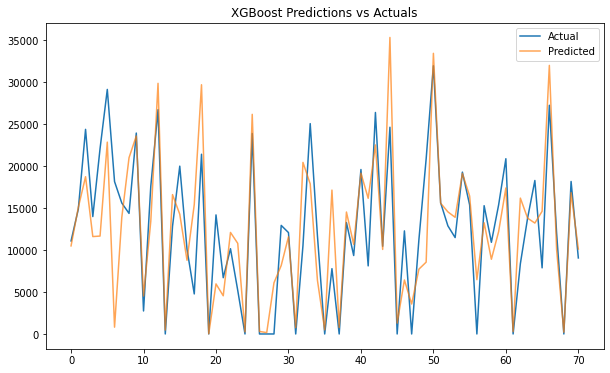

In [69]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('XGBoost Predictions vs Actuals')
plt.legend()
plt.show()

#### The Mean Squared Error (MSE) of 26,631,917 is quite large, indicating that the model's predictions may not be very close to the actual values

In [70]:
# Normalizing the Data

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           verbose=1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [72]:
# Use the best model
best_xgb_model = grid_search.best_estimator_

# Train the model with the best parameters
best_xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tuned = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f"Tuned XGBoost MSE: {mse_tuned}")

Tuned XGBoost MSE: 23558439.60557238


### Using MinMaxScaler

In [73]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [74]:
# Add more rolling statistics
df_daily['Rolling_Std_7'] = df_daily['Quantity'].rolling(window=7).std()
df_daily['Rolling_Exp_Mean'] = df_daily['Quantity'].ewm(span=7, adjust=False).mean()

# Recreate lagged features
df_lagged = create_lagged_features(df_daily[['Quantity', 'Rolling_Mean_7', 'Rolling_Std_7', 'Rolling_Exp_Mean']])


### Train the XGBoost Model with New Features

In [75]:
# Define features (X) and target (y)
X = df_lagged.drop('Quantity', axis=1)  # Use the lagged features, rolling means, and standard deviation
y = df_lagged['Quantity']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model with the tuned parameters from earlier or default values
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with New Features: {mse}')


Mean Squared Error with New Features: 16070774.55697923


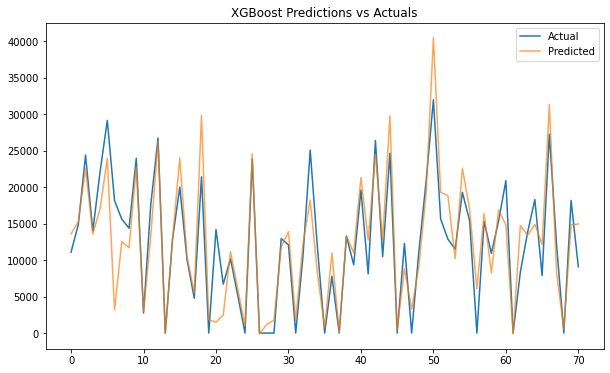

In [76]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('XGBoost Predictions vs Actuals')
plt.legend()
plt.show()

In [77]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Use the best model
best_xgb_model = grid_search.best_estimator_

# Re-evaluate the tuned model
y_pred_tuned = best_xgb_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f'Tuned XGBoost MSE: {mse_tuned}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Tuned XGBoost MSE: 8135519.6312320875


### Cross-validation to ensure the model's performance generalizes well across different subsets of the data

In [78]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate average MSE
mean_cv_mse = -cv_scores.mean()
print(f"Cross-validated MSE: {mean_cv_mse}")


Cross-validated MSE: 29413039.479570676


# Using LightGBM, which is a gradient boosting framework that's known for its speed and efficiency.

In [79]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [80]:
# Initialize the LightGBM regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print(f'LightGBM MSE: {mse_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 10
[LightGBM] [Info] Start training from score 13228.558304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

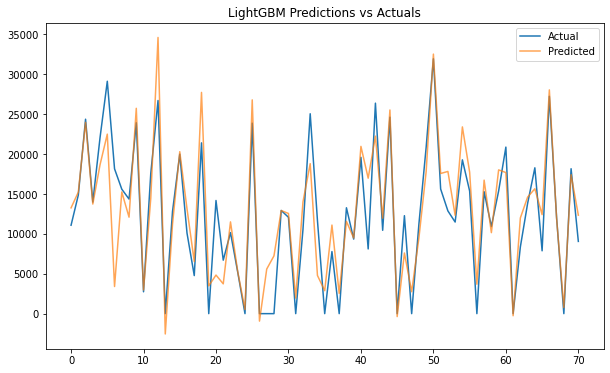

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lgb, label='Predicted', alpha=0.7)
plt.title('LightGBM Predictions vs Actuals')
plt.legend()
plt.show()

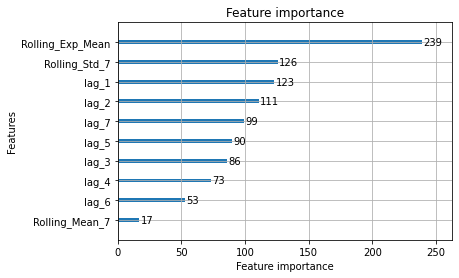

In [82]:
# Re-examine Feature Importance
lgb.plot_importance(lgb_model, max_num_features=10)
plt.show()


###  Remove Less Important Features

In [83]:
# Drop less important features
X_train_reduced = X_train.drop(columns=['Rolling_Mean_7']) 
X_test_reduced = X_test.drop(columns=['Rolling_Mean_7'])

#### Retrain the LightGBM Model

In [84]:
# Initialize the LightGBM model again
lgb_model_reduced = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model with reduced features
lgb_model_reduced.fit(X_train_reduced, y_train)

# Make predictions with the reduced model
y_pred_reduced = lgb_model_reduced.predict(X_test_reduced)

# Evaluate the model using Mean Squared Error (MSE)
mse_reduced = mean_squared_error(y_test, y_pred_reduced)
print(f'LightGBM MSE after removing less important features: {mse_reduced}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 283, number of used features: 9
[LightGBM] [Info] Start training from score 13228.558304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

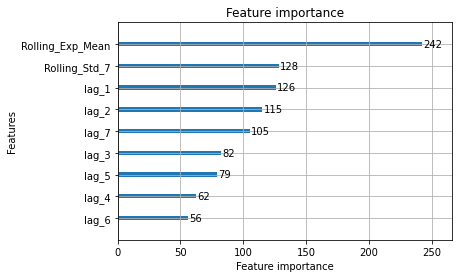

In [85]:
lgb.plot_importance(lgb_model_reduced, max_num_features=10)
plt.show()


### Moving on to using an LSTM model

In [86]:
# Scale the features for LSTM (LSTM models usually perform better with scaled data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input data to 3D for LSTM
def create_lstm_data(X, y, time_steps=10):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i+time_steps, :])
        y_lstm.append(y[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

time_steps = 10
X_lstm, y_lstm = create_lstm_data(X_scaled, y.values, time_steps)

# Split the data into training and testing sets
X_train_lstm, X_test_lstm = X_lstm[:int(0.8*len(X_lstm))], X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm, y_test_lstm = y_lstm[:int(0.8*len(y_lstm))], y_lstm[int(0.8*len(y_lstm)):]

### Build the LSTM Model

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/50


/mmfs1/home/oreoluwa.alade/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 205541504.0000 - val_loss: 568674944.0000
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 200170096.0000 - val_loss: 568516608.0000
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 207735072.0000 - val_loss: 568421248.0000
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 195296720.0000 - val_loss: 568371008.0000
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 205535968.0000 - val_loss: 568340352.0000
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 192296544.0000 - val_loss: 568315008.0000
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 212581056.0000 - val_loss: 568291200.0000
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 201334592.0000 - val_loss: 568268544.0000
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 203072448.0000 - val_loss: 568246208.0000
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 201333632.0000 - val_loss: 568224512.0000
Epoch 11/50
9/9 ━━━━━━━━━━━━━

In [88]:
# Create a separate scaler for the target variable (y)
scaler_y = MinMaxScaler()

# Fit the scaler on the training target values
y_train_scaled = scaler_y.fit_transform(y_train_lstm.reshape(-1, 1))

# Train the LSTM model again (if needed, or use the one you've already trained)
history = model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1037.5190 - val_loss: 567418304.0000
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1034.7612 - val_loss: 567413760.0000
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1028.4188 - val_loss: 567412032.0000
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1053.9730 - val_loss: 567411456.0000
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1058.6285 - val_loss: 567411200.0000
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1047.3792 - val_loss: 567411072.0000
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1047.9648 - val_loss: 567411072.0000
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1051.3789 - val_loss: 567411200.0000
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1068.5728 - val_loss: 567411264.0000
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1062.3102 - val_loss: 567411264.0000
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1056.1652 -

In [89]:
# Make predictions
y_pred_lstm = model.predict(X_test_lstm)

# Rescale predictions back to the original scale (using the target scaler)
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)

# Rescale the true y_test values as well (if you want to compare directly)
y_test_rescaled = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate the MSE
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm_rescaled)
print(f'LSTM Model MSE: {mse_lstm}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
LSTM Model MSE: 1.030978120755879e+18


### The LSTM Model MSE is extremely large, which indicates that something might be off in the training process or in the scaling of the data

In [90]:
# Scale the test target values (y_test_lstm) using the same scaler as y_train_lstm
y_test_scaled = scaler_y.transform(y_test_lstm.reshape(-1, 1))


In [91]:
from tensorflow.keras.optimizers import Adam

# Adjust the learning rate of the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Retrain the model
history = model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_scaled))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1052.6255 - val_loss: 1002.2814
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1013.2228 - val_loss: 956.5704
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 746.0313 - val_loss: 107.4410
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.8526 - val_loss: 0.7235
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2554 - val_loss: 0.0886
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0501 - val_loss: 0.1869
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0650 - val_loss: 0.2311
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0727 - val_loss: 0.2333
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0709 - val_loss: 0.2168
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0816 - val_loss: 0.1949
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0679 - val_loss: 0.1759
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0683 - val_loss: 0.1

In [92]:
# Make predictions
y_pred_lstm = model.predict(X_test_lstm)

# Rescale the predictions back to the original scale
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)

# Rescale the actual test target values
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate MSE
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm_rescaled)
print(f'LSTM Model MSE: {mse_lstm}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
LSTM Model MSE: 196905705.94761294


###  Increasing the Number of Epochs for the LSTM model

In [93]:
history = model.fit(X_train_lstm, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_scaled))


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - val_loss: 0.1073
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0437 - val_loss: 0.1064
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0455 - val_loss: 0.1052
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0490 - val_loss: 0.1058
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0524 - val_loss: 0.1070
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0473 - val_loss: 0.1059
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0469 - val_loss: 0.1036
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - val_loss: 0.1041
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0454 - val_loss: 0.1043
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0488 - val_loss: 0.1063
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0489 - val_loss: 0.1066
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0503 - val_loss: 0.1068


In [94]:
from tensorflow.keras.callbacks import EarlyStopping

# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_lstm, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_scaled), callbacks=[early_stop])


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0438 - val_loss: 0.0920
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0376 - val_loss: 0.0910
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0456 - val_loss: 0.0921
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0390 - val_loss: 0.0923
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0409 - val_loss: 0.0919
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0417 - val_loss: 0.0916
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0367 - val_loss: 0.0923


In [95]:
# Make predictions on the test data
y_pred_lstm = model.predict(X_test_lstm)

# Rescale predictions back to the original scale
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)

# Rescale the actual y_test values
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate the Mean Squared Error
from sklearn.metrics import mean_squared_error
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm_rescaled)
print(f'LSTM Model MSE after Early Stopping: {mse_lstm}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model MSE after Early Stopping: 165280655.05217785


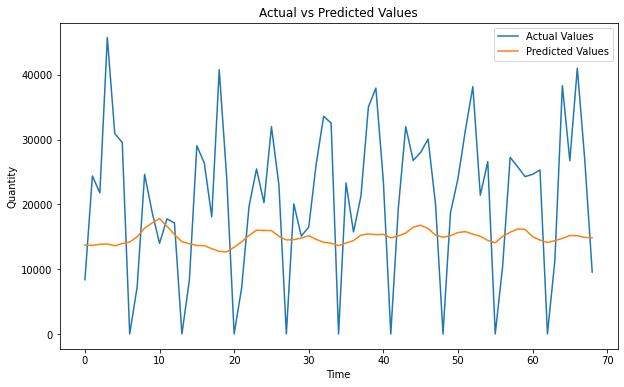

In [96]:
# Plot the actual values and the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Values')
plt.plot(y_pred_lstm_rescaled, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()

### Transitioning to a Feedforward Neural Network (FFN)

In [97]:
# Preprocessing step (assuming df_lagged contains the final processed features)

# Define features (X) and target (y)
X = df_lagged.drop('Quantity', axis=1)
y = df_lagged['Quantity']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the FFN model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))  # Input layer + first hidden layer
model.add(Dense(64, activation='relu'))  # Second hidden layer
model.add(Dense(32, activation='relu'))  # Third hidden layer
model.add(Dense(1))  # Output layer for regression (single output)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print model summary
model.summary()


/mmfs1/home/oreoluwa.alade/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stop])


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1607 - val_loss: 0.0308
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - val_loss: 0.0333
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0221
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.0186
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.0141
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0133
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0107
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.0080
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0083
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0061


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Feedforward Neural Network MSE: 1315914.091646287


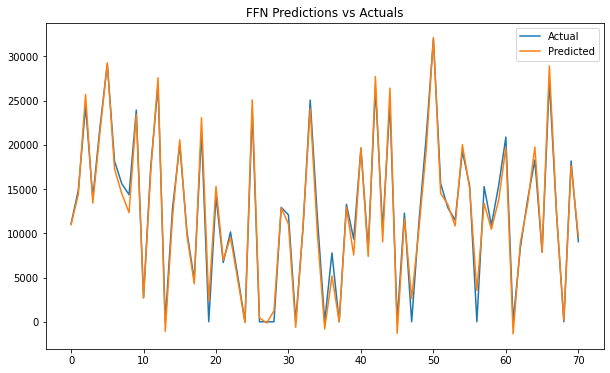

In [100]:

# Make predictions on the test set
y_pred_ffn = model.predict(X_test_scaled)

# Rescale the predictions and test data back to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred_ffn)
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate Mean Squared Error
mse_ffn = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Feedforward Neural Network MSE: {mse_ffn}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('FFN Predictions vs Actuals')
plt.legend()
plt.show()

In [101]:
# Calculate Mean Squared Error
mse_ffn = mean_squared_error(y_test_rescaled, y_pred_rescaled)

# Calculate Root Mean Squared Error (RMSE)
rmse_ffn = np.sqrt(mse_ffn)
print(f'Feedforward Neural Network RMSE: {rmse_ffn}')

Feedforward Neural Network RMSE: 1147.1329877770436


#### The Feedforward Neural Network (FFN) significantly outperforms the other models with the lowest RMSE of 1147.1329877770436

## Trying the Random forest model

/mmfs1/home/oreoluwa.alade/.local/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest MSE: 14763330.458377462
Random Forest RMSE: 3842.3079598566096


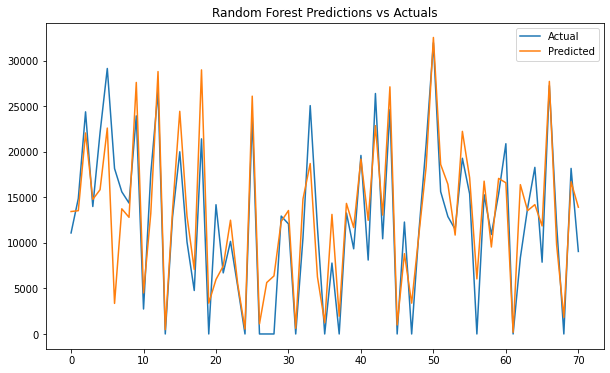

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Rescale the predictions back to the original scale
y_pred_rf_rescaled = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled)

# Calculate Mean Squared Error and RMSE
mse_rf = mean_squared_error(y_test_rescaled, y_pred_rf_rescaled)
rmse_rf = np.sqrt(mse_rf)
print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest RMSE: {rmse_rf}')

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rf_rescaled, label='Predicted')
plt.title('Random Forest Predictions vs Actuals')
plt.legend()
plt.show()


#### The Random Forest model produced an RMSE of 3842.31, which is significantly higher than the Feedforward Neural Network's RMSE of 1147.13.

### Increasing the Epochs with Early Stopping

In [45]:
# Try increasing the number of epochs, and keep the patience of early stopping.
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stop])


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6723e-04 - val_loss: 6.9922e-04
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9365e-04 - val_loss: 6.7146e-04
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7842e-04 - val_loss: 8.0627e-04
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7467e-04 - val_loss: 8.2199e-04
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4699e-04 - val_loss: 8.0094e-04
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5703e-04 - val_loss: 6.5688e-04
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1414e-04 - val_loss: 6.7073e-04
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4920e-04 - val_loss: 6.8836e-04
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3271e-04 - val_loss: 6.6786e-04
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1699e-04 - val_loss: 7.7168e-04
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1592e-04 - val_loss: 6.9007e-

In [48]:
# Assuming the scaler was fitted on a DataFrame, we will inverse transform only the relevant column (target variable).
# Extract the scaler's data range
target_min = scaler.data_min_[-1]  # Assuming y was the last feature
target_max = scaler.data_max_[-1]

# Manually rescale the predictions back to the original scale
y_pred_ffn_rescaled = y_pred_ffn * (target_max - target_min) + target_min

# Rescale the actual test data in a similar way
y_test_rescaled = y_test_scaled * (target_max - target_min) + target_min


Feedforward Neural Network MSE: 247065783.3381533


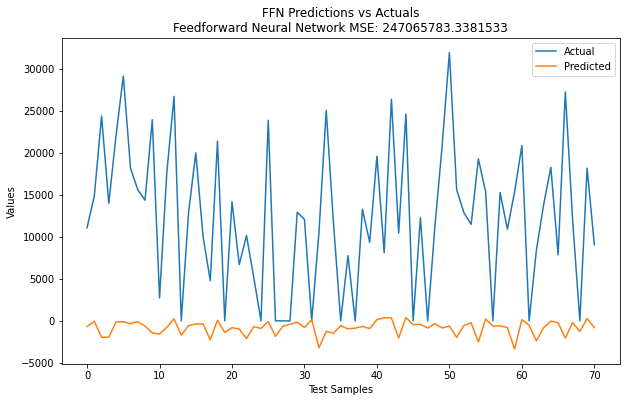

In [49]:
# Calculate the Mean Squared Error (MSE)
mse_ffn = mean_squared_error(y_test_rescaled, y_pred_ffn_rescaled)
print(f"Feedforward Neural Network MSE: {mse_ffn}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_ffn_rescaled, label='Predicted')
plt.title(f'FFN Predictions vs Actuals\nFeedforward Neural Network MSE: {mse_ffn}')
plt.xlabel('Test Samples')
plt.ylabel('Values')
plt.legend()
plt.show()
